In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import seaborn as sns

In [2]:
plt.set_cmap('coolwarm')

<Figure size 432x288 with 0 Axes>

In [3]:
np.set_printoptions(threshold=10, precision=6)
sigmoid = lambda x: 1 / (1 + np.exp(-x))

# Multiclass Classification

### Generating Bivariate Classification Data

In [4]:
def generate_bivariate_data(size, classes=2, angle=None, sep=1, noise=1.5):
    x_c = np.linspace(-sep, sep, classes) * classes
    y_c = np.random.permutation(x_c)
    X = np.concatenate([np.random.normal(loc=(x_c[i], y_c[i]), 
                                         scale=noise, 
                                         size=(size // classes, 2)) for i in range(classes)], axis=0)
    y = np.concatenate([np.zeros(size // classes) + i for i in range(classes)], axis=0)
    angle = angle if angle else np.random.randint(0, 181)
    theta = np.pi / 180 * angle
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    return X, y

### Number of Classes = 4

In [5]:
X, y = generate_bivariate_data(1000, classes=4)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (800, 2)
X_test shape :  (200, 2)
y_train shape :  (800,)
y_test shape :  (200,)


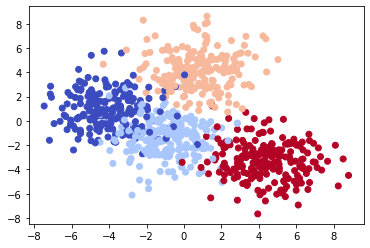

In [8]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Logistic Regression Model for Binary Classification

In [9]:
class BinaryClassifier:
    def __init__(self, n_features, degree=1, normalize=True):
        self.__n_features = n_features
        self.__degree = degree
        self.weights = np.random.randn(n_features * degree + 1) 
        self.__normalize = normalize
        self.__scaling_params = (0, 1)
            
    def __transform(self, X, training=False, normalize=True):
        X_init = X
        for i in range(2, self.__degree + 1):
            X = np.c_[X, X_init ** i]
        if training:
            self.__scaling_params = (X.mean(axis=0), X.std(axis=0))
        if self.__normalize:
            mu, s = self.__scaling_params
            X = (X - mu) / (s + 1e-9)
        return np.c_[np.ones((X.shape[0], 1)), X].T  
    
    def fit(self, X, y, epochs=1, batch_size=None, alpha=0.001, verbose=True):
        X = self.__transform(X, training=True)
        for i in range(epochs):
            y_pred = sigmoid(self.weights.T @ X)
            self.weights -= alpha * np.mean((y_pred - y) * X, axis=1)
            
    def predict(self, X):
        y_pred = sigmoid(self.weights.T @ self.__transform(X))
        return y_pred

### Multiclass Logistic Regression Model using Binary Classifier

In [10]:
class MulticlassClassifier:
    def __init__(self, n_features, n_classes, degree=1, weights=None, normalize=True):
        self.__n_features = n_features
        self.__n_classes = n_classes
        self.__degree = degree
        self.__normalize = normalize
        self.__models = [BinaryClassifier(n_features=n_features, 
                                          degree=degree, 
                                          normalize=normalize) for _ in range(n_classes)]
        self.weights = weights
        self.metrics = None
            
    
    def fit(self, X, y, epochs=1, batch_size=None, alpha=0.001, verbose=True):
        loss_per_epochs, acc_per_epochs = [], []
        for i in range(epochs):
            J, acc = 0, 0
            for j in range(self.__n_classes):
                self.__models[j].fit(X, y == j, alpha=alpha, verbose=False)
            J, acc = self.evaluate(X, y).values()
            loss_per_epochs.append(J)
            acc_per_epochs.append(acc)   
            if verbose:
                print(f'Epoch {i+1}/{epochs}\n{X.shape[-1]}/{X.shape[-1]} [==============] : loss = {J:.6f}\t acc = {acc}')
        self.metrics = {'loss_per_epochs' : loss_per_epochs, 'acc_per_epochs' : acc_per_epochs}
        self.weights = np.array([model.weights for model in self.__models])
          
    def predict(self, X, predict_probs=False):
        y_pred = [None] * self.__n_classes
        for i in range(self.__n_classes):
            y_pred[i] = self.__models[i].predict(X)
        y_pred = np.c_[y_pred].T
        y_pred /= y_pred.sum(axis=1, keepdims=True)
        if not predict_probs:
            y_pred = y_pred.argsort()[:, -1]
        return y_pred
    
    def evaluate(self, X, y):
        y_pred = self.predict(X, predict_probs=True)
        y_true = tf.keras.utils.to_categorical(y)
        J = -np.sum(np.mean(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9), axis=0))
        acc = np.mean((y_pred.argsort()[:, -1] == y))
        evaluation = {'loss' : J, 'accurracy' : acc}
        return evaluation
    
    def get_weights(self):
        """returns weights as a dict object with keys - `weights` and `bias`"""
        model_weights = {'weights' : self.weights[:, 1:], 'bias' : self.weights[:, 0]}
        return model_weights 
    
    def plot_decision_boundary(self, X, y, figsize=(7,7), ec='white', s=50,alpha=0.8):
        plt.figure(figsize=figsize)
        x1 = np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.1)
        x2 = np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, 0.1)

        X1, X2 = np.meshgrid(x1, x2)
        X1, X2 = X1.ravel(), X2.ravel() 
        preds = model.predict(np.c_[X1, X2]).reshape(x2.shape[0], x1.shape[0])

        extent=[X[:, 0].min() - 1, X[:, 0].max() + 1, X[:, 1].min() - 1, X[:, 1].max() + 1]
        plt.imshow(preds, origin='lower', extent=extent, alpha=alpha, aspect='auto')
        plt.scatter(X[:, 0], X[:, 1], c=y, ec=ec, s=s)

In [11]:
model = MulticlassClassifier(n_features=2, n_classes=4, degree=2)

In [12]:
model.fit(X, y, epochs=200, alpha=1)

Epoch 1/200
2/2 [==============] : loss = 2.134008	 acc = 0.294
Epoch 2/200
2/2 [==============] : loss = 1.706136	 acc = 0.603
Epoch 3/200
2/2 [==============] : loss = 1.454370	 acc = 0.737
Epoch 4/200
2/2 [==============] : loss = 1.301400	 acc = 0.833
Epoch 5/200
2/2 [==============] : loss = 1.196417	 acc = 0.868
Epoch 6/200
2/2 [==============] : loss = 1.118231	 acc = 0.891
Epoch 7/200
2/2 [==============] : loss = 1.057146	 acc = 0.902
Epoch 8/200
2/2 [==============] : loss = 1.007840	 acc = 0.908
Epoch 9/200
2/2 [==============] : loss = 0.967055	 acc = 0.913
Epoch 10/200
2/2 [==============] : loss = 0.932656	 acc = 0.912
Epoch 11/200
2/2 [==============] : loss = 0.903177	 acc = 0.916
Epoch 12/200
2/2 [==============] : loss = 0.877574	 acc = 0.915
Epoch 13/200
2/2 [==============] : loss = 0.855086	 acc = 0.913
Epoch 14/200
2/2 [==============] : loss = 0.835139	 acc = 0.913
Epoch 15/200
2/2 [==============] : loss = 0.817295	 acc = 0.912
Epoch 16/200
2/2 [==============] 

In [13]:
model.predict(X)

array([0, 1, 0, ..., 1, 3, 3])

In [14]:
model.evaluate(X, y)

{'loss': 0.47951881799339746, 'accurracy': 0.911}

In [15]:
model.get_weights()

{'weights': array([[-2.835012,  1.444246,  1.409226, -1.733161],
        [-1.528013, -2.558561, -3.497746, -1.670004],
        [ 2.330155,  3.909085, -1.800605,  0.880468],
        [ 3.652648, -2.474488,  1.772639, -0.236335]]),
 'bias': array([-2.858681, -3.601397, -2.925683, -2.824682])}

Text(0.5, 1.0, 'Training Accuracy')

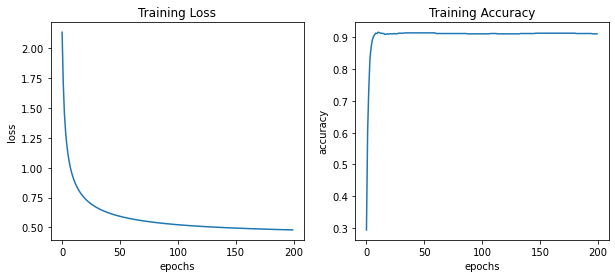

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

### Evaluation

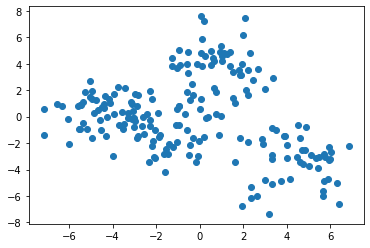

In [17]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [18]:
model.evaluate(X_test, y_test)

{'loss': 0.39924461459334903, 'accurracy': 0.93}

In [19]:
y_pred = model.predict(X_test)

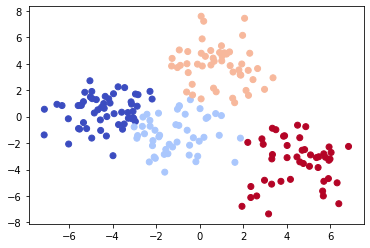

In [20]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### Decision Boundary

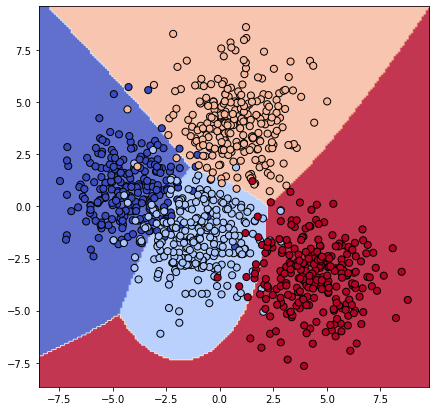

In [21]:
model.plot_decision_boundary(X, y, ec='k')